Obtain and preprocess the data

In [4]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths and constants
BASE_DIR = "../Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification/data/kaggle_dogs_vs_cats_small"  # Update with your dataset path
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
SAMPLES = 5000

# Data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    validation_split=0.1  # 10% validation split
)

train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 4500 images belonging to 3 classes.
Found 500 images belonging to 3 classes.
Found 5000 images belonging to 3 classes.


2. Exploratory Data Analysis (EDA)

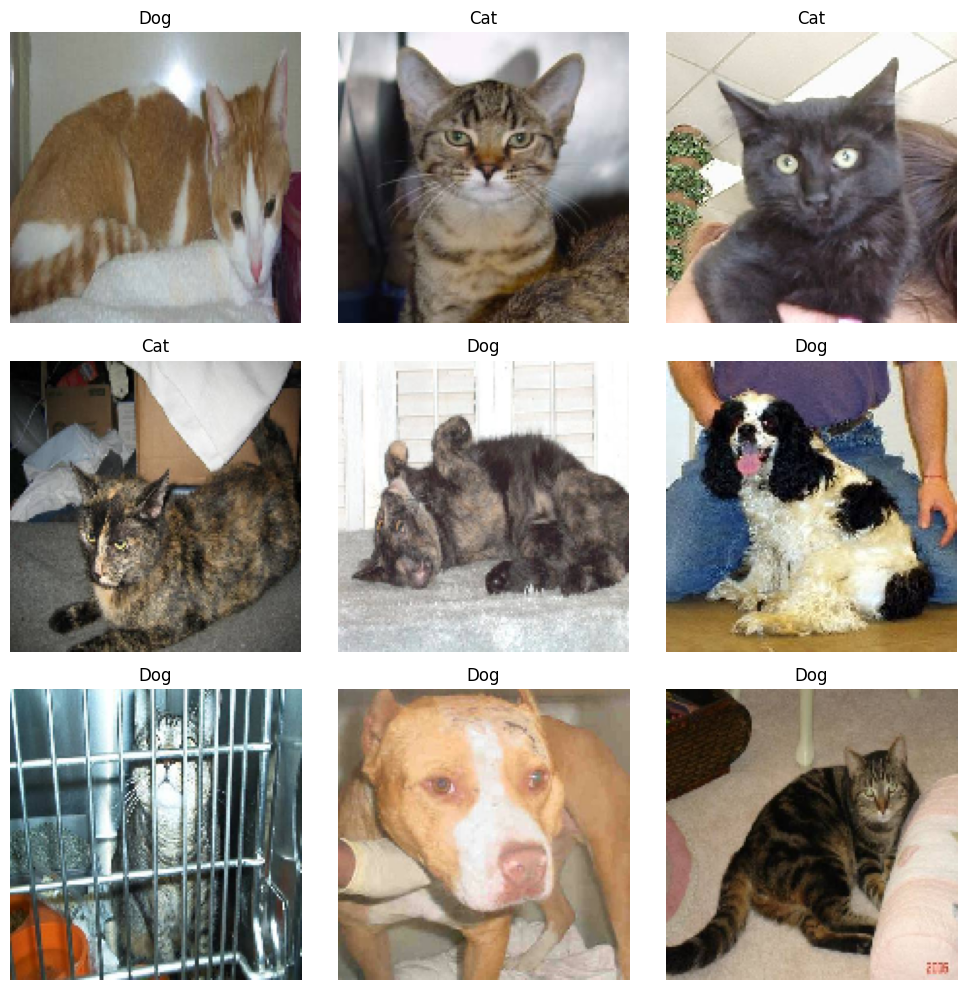

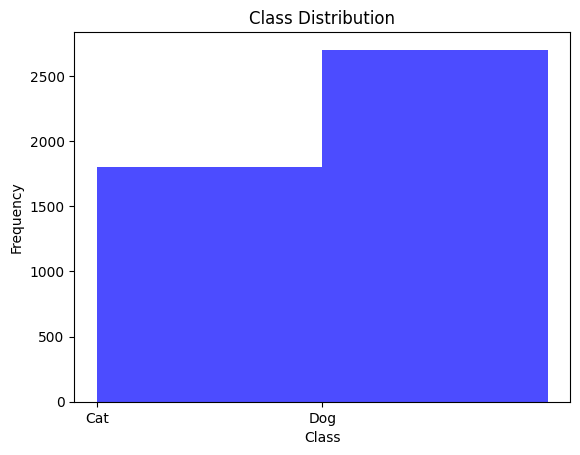

In [5]:
# Visualize sample images
def plot_samples(generator):
    x_batch, y_batch = next(generator)
    if x_batch.shape[0] == 0:
        print("No images to display.")
        return
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(9):
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')
        axes[i].set_title("Cat" if y_batch[i] == 0 else "Dog")
    plt.tight_layout()
    plt.show()

plot_samples(train_generator)

# Class distribution
labels = train_generator.classes
plt.hist(labels, bins=2, color='blue', alpha=0.7)
plt.title("Class Distribution")
plt.xticks([0, 1], ["Cat", "Dog"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


3. Define and Train Models
Custom Neural Network

In [6]:
from tensorflow.keras import layers, models, callbacks

# Define CNN
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cnn = callbacks.ModelCheckpoint(
    'cnn_model_best.h5', save_best_only=True, monitor='val_loss'
)

# Train
cnn_history = cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint_cnn]
)


Epoch 1/20
141/141 [==============================] - 57s 396ms/step - loss: 0.5373 - accuracy: 0.4020 - val_loss: 0.5201 - val_accuracy: 0.4000
Epoch 2/20
141/141 [==============================] - 56s 400ms/step - loss: 0.5159 - accuracy: 0.4000 - val_loss: 0.5035 - val_accuracy: 0.4000
Epoch 3/20
141/141 [==============================] - 58s 410ms/step - loss: 0.5242 - accuracy: 0.4000 - val_loss: 0.4984 - val_accuracy: 0.4000
Epoch 4/20
141/141 [==============================] - 64s 456ms/step - loss: 0.5111 - accuracy: 0.4000 - val_loss: 0.4969 - val_accuracy: 0.4000
Epoch 5/20
141/141 [==============================] - 58s 414ms/step - loss: 0.5112 - accuracy: 0.4000 - val_loss: 0.4926 - val_accuracy: 0.4000
Epoch 6/20
141/141 [==============================] - 58s 408ms/step - loss: 0.4814 - accuracy: 0.4004 - val_loss: 0.4961 - val_accuracy: 0.4000
Epoch 7/20
141/141 [==============================] - 59s 419ms/step - loss: 0.3930 - accuracy: 0.4133 - val_loss: 0.6479 - val_ac

Fine-Tuned VGG16


In [7]:
from tensorflow.keras.applications import VGG16

# Load VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_vgg = callbacks.ModelCheckpoint(
    'vgg_model_best.h5', save_best_only=True, monitor='val_loss'
)

# Train
vgg_history = vgg_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint_vgg]
)


Epoch 1/20
141/141 [==============================] - 293s 2s/step - loss: 0.6034 - accuracy: 0.4022 - val_loss: 0.5286 - val_accuracy: 0.4000
Epoch 2/20
141/141 [==============================] - 288s 2s/step - loss: 0.5277 - accuracy: 0.4027 - val_loss: 0.5463 - val_accuracy: 0.4000
Epoch 3/20
141/141 [==============================] - 289s 2s/step - loss: 0.5067 - accuracy: 0.4000 - val_loss: 0.5114 - val_accuracy: 0.4000
Epoch 4/20
141/141 [==============================] - 305s 2s/step - loss: 0.4490 - accuracy: 0.4000 - val_loss: 0.5097 - val_accuracy: 0.4000
Epoch 5/20
141/141 [==============================] - 374s 3s/step - loss: 0.4153 - accuracy: 0.4000 - val_loss: 0.5075 - val_accuracy: 0.4000
Epoch 6/20
141/141 [==============================] - 332s 2s/step - loss: 0.4061 - accuracy: 0.4000 - val_loss: 0.5346 - val_accuracy: 0.4000
Epoch 7/20
141/141 [==============================] - 312s 2s/step - loss: 0.3417 - accuracy: 0.4000 - val_loss: 0.5572 - val_accuracy: 0.4000

4. Evaluate Models

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# Load best models
cnn_model.load_weights('cnn_model_best.h5')
vgg_model.load_weights('vgg_model_best.h5')

# Evaluate and predict
cnn_preds = (cnn_model.predict(test_generator, steps=None) > 0.5).astype(int).flatten()
vgg_preds = (vgg_model.predict(test_generator, steps=None) > 0.5).astype(int).flatten()

# Confusion matrix and classification report
print("CNN Model")
print(confusion_matrix(test_generator.classes, cnn_preds))
print(classification_report(test_generator.classes, cnn_preds))

print("VGG Model")
print(confusion_matrix(test_generator.classes, vgg_preds))
print(classification_report(test_generator.classes, vgg_preds))

# Precision-recall curve
def plot_precision_recall(y_true, y_pred, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=f'{model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

plot_precision_recall(test_generator.classes, cnn_preds, "CNN Model")
plot_precision_recall(test_generator.classes, vgg_preds, "VGG Model")


157/157 [==============================] - 316s 2s/step
CNN Model
[[   0 2000    0]
 [   0 2000    0]
 [   0 1000    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2000
           1       0.40      1.00      0.57      2000
           2       0.00      0.00      0.00      1000

    accuracy                           0.40      5000
   macro avg       0.13      0.33      0.19      5000
weighted avg       0.16      0.40      0.23      5000

VGG Model
[[   0 2000    0]
 [   0 2000    0]
 [   0 1000    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2000
           1       0.40      1.00      0.57      2000
           2       0.00      0.00      0.00      1000

    accuracy                           0.40      5000
   macro avg       0.13      0.33      0.19      5000
weighted avg       0.16      0.40      0.23      5000



c:\Python VIrtual Environments\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python VIrtual Environments\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python VIrtual Environments\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

ValueError: multiclass format is not supported

5. Error Analysis

In [ ]:
import numpy as np

def display_errors(generator, y_true, y_pred, model_name):
    errors = np.where(y_true != y_pred)[0]
    print(f"\n{len(errors)} Errors in {model_name}")
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    for i, error in enumerate(errors[:9]):
        x_batch, _ = generator[error // generator.batch_size]
        img_idx = error % generator.batch_size
        axes[i].imshow(x_batch[img_idx])
        axes[i].set_title(f"True: {y_true[error]}, Pred: {y_pred[error]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display errors
display_errors(test_generator, test_generator.classes, cnn_preds, "CNN Model")
display_errors(test_generator, test_generator.classes, vgg_preds, "VGG Model")
